In [2]:
from pointpats.geometry import(TREE_TYPES)
import pandas as pd
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import PointPattern
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
from pointpats.geometry import (
    area as _area,
    bbox as _bbox,
    contains as _contains,
    k_neighbors as _k_neighbors,
    build_best_tree as _build_best_tree,
    prepare_hull as _prepare_hull,
)
import numpy 

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

In [3]:
def _prepare(coordinates, support, distances, metric, hull, edge_correction):
    """
    prepare the arguments to convert into a standard format
    1. cast the coordinates to a numpy array
    2. precomputed metrics must have distances provided
    3. metrics must be callable or string
    4. warn if distances are specified and metric is not default
    5. make distances a numpy.ndarray
    6. construct the support, accepting:
        - num_steps -> a linspace with len(support) == num_steps
                       from zero to a quarter of the bounding box's smallest side
        - (stop, ) -> a linspace with len(support) == 20
                 from zero to stop
        - (start, stop) -> a linspace with len(support) == 20
                           from start to stop
        - (start, stop, num_steps) -> a linspace with len(support) == num_steps
                                      from start to stop
        - numpy.ndarray -> passed through
    """
    # Throw early if edge correction is requested
    if edge_correction is not None:
        raise NotImplementedError("Edge correction is not currently implemented.")

    # cast to coordinate array
    if isinstance(coordinates, TREE_TYPES):
        tree = coordinates
        coordinates = tree.data
    else:
        coordinates = numpy.asarray(coordinates)
    hull = _prepare_hull(coordinates, hull)

    # evaluate distances
    if (distances is None) and metric == "precomputed":
        raise ValueError(
            "If metric =`precomputed` then distances must"
            " be provided as a (n,n) numpy array."
        )
    if not (isinstance(metric, str) or callable(metric)):
        raise TypeError(
            f"`metric` argument must be callable or a string. Recieved: {metric}"
        )
    if distances is not None and metric != "euclidean":
        warnings.warn(
            "Distances were provided. The specified metric will be ignored."
            " To use precomputed distances with a custom distance metric,"
            " do not specify a `metric` argument.",
            stacklevel=2,
        )
        metric = "euclidean"

    if support is None:
        support = 20

    if isinstance(support, int):  # if just n_steps, use the max nnd
        # this is O(n log n) for kdtrees & balltrees
        tmp_tree = _build_best_tree(coordinates, metric=metric)
        max_dist = _k_neighbors(tmp_tree, coordinates, 1)[0].max()
        support = numpy.linspace(0, max_dist, num=support)
    # otherwise, we need to build it using (start, stop, step) semantics
    elif isinstance(support, tuple):
        if len(support) == 1:  # assuming this is with zero implicit start
            support = numpy.linspace(0, support[0], num=20)  # default support n bins
        elif len(support) == 2:
            support = numpy.linspace(*support, num=20)  # default support n bins
        elif len(support) == 3:
            support = numpy.linspace(support[0], support[1], num=support[2])
    else:  # try to use it as is
        try:
            support = numpy.asarray(support)
        except:
            raise TypeError(
                "`support` must be a tuple (either (start, stop, step), (start, stop) or (stop,)),"
                " an int describing the number of breaks to use to evalute the function,"
                " or an iterable containing the breaks to use to evaluate the function."
                " Recieved object of type {}: {}".format(type(support), support)
            )

    return coordinates, support, distances, metric, hull, edge_correction

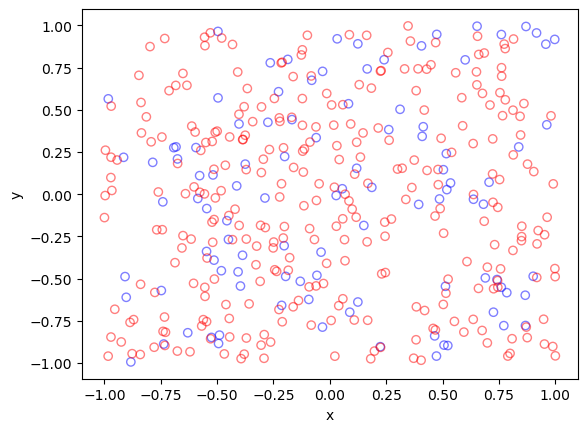

In [24]:
import numpy as np 
import matplotlib.pyplot as plt
 
# Simulation window parameters
xMin=-1;xMax=1
yMin=-1;yMax=1
xDelta=xMax-xMin
yDelta=yMax-yMin # rectangle dimensions
areaTotal=xDelta*yDelta
 
# Point process parameters
lambda0=100 # intensity (ie mean density) of the Poisson process
 
# Thinning probability
p=0.25
 
# Simulate a Poisson point process
numbPoints = np.random.poisson(lambda0*areaTotal) # Poisson number of points
xx = np.random.uniform(0,xDelta,((numbPoints,1)))+xMin #x coordinates of Poisson points
yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin #y coordinates of Poisson points
 
# Generate Bernoulli variables (ie coin flips) for thinning
booleThinned=np.random.uniform(0,1,((numbPoints,1)))>p # points to be thinned
booleRetained=~booleThinned # points to be retained
 
# x/y locations of thinned points
xxThinned=xx[booleThinned]
yyThinned=yy[booleThinned]
# x/y locations of retained points
xxRetained=xx[booleRetained]
yyRetained=yy[booleRetained]
 
# Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', facecolor='none', alpha=0.5 )
plt.scatter(xxThinned,yyThinned, edgecolor='r', facecolor='none', alpha=0.5 )
plt.xlabel("x"); plt.ylabel("y")
plt.show()

In [38]:
xxThinned == xxRetained

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_71057/4234847394.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  xxThinned == xxRetained


False

In [29]:
data = pd.DataFrame({'x':xxRetained, 'y':yyRetained})

In [30]:
xy = data[['x', 'y']].values

In [12]:
def kinhom(coords_array):
    coordinates, support, distances, metric, hull, edge_correction = _prepare(
            coords_array, support=None,
        distances=None,
        metric="euclidean",
        hull=None,
        edge_correction=None,
        )

    hull = _prepare_hull(coords_array, hull = None)

    n = coordinates.shape[0]
    upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
    n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
    lambda_1 = n / _area(hull) #INTENSITY 
    k_estimate = ((n_pairs_less_than_d * 2) / n) / lambda_1 # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
    uno_fratto_a = 1/ _area(hull)
    lambda_2 = (n * (n - 1)) / (_area(hull))**2
    k_inhom_estimate = ((n_pairs_less_than_d *2) / (lambda_2)) * uno_fratto_a
    return support, k_inhom_estimate

In [13]:
numatax = pd.read_csv('/Users/gocchini/numatax.csv')
numatay = pd.read_csv('/Users/gocchini/numatay.csv')
numatax = numatax['x'].tolist()
numatay = numatay['x'].tolist()
numata_array = np.array(list(zip(numatax, numatay)))

In [22]:
numata_res = kinhom(numata_array)

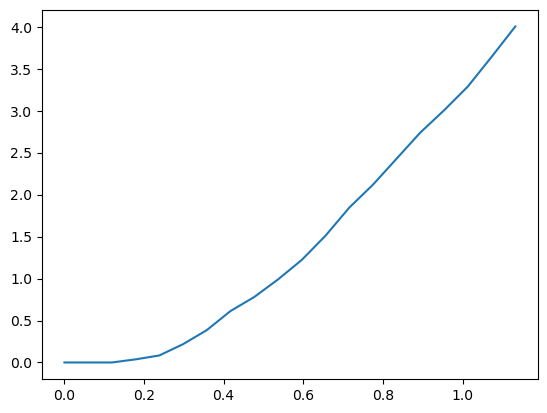

In [23]:
plt.plot(numata_res[0], numata_res[1])

In [25]:
simdata = pd.DataFrame({'x':xxRetained, 'y':yyRetained})
simdataxy = simdata[['x', 'y']].values

In [26]:
res_sim = kinhom(simdataxy)

#  normalize so that they are between 0 and 1 before plotting

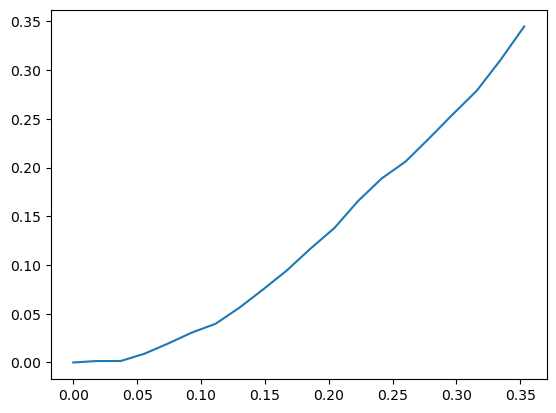

In [27]:
plt.plot(res_sim[0], res_sim[1])

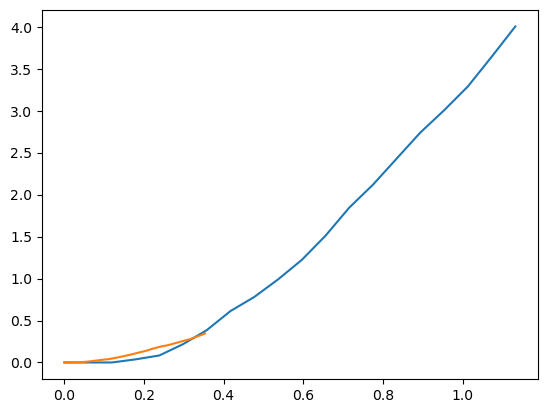

In [28]:
plt.plot(numata_res[0], numata_res[1])
plt.plot(res_sim[0], res_sim[1])

# WORKING 

In [13]:
upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
lambda_1 = n / _area(hull) #INTENSITY 
k_estimate = ((n_pairs_less_than_d * 2) / n) / lambda_1 # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
uno_fratto_a = 1/ _area(hull)
lambda_2 = (n * (n - 1)) / (_area(hull))**2
k_inhom_estimate = ((n_pairs_less_than_d *2) / (lambda_2)) * uno_fratto_a

In [106]:
numata_array

array([[1.62182, 0.34091],
       [1.48182, 0.80455],
       [0.89091, 0.99545],
       [1.32182, 1.09091],
       [3.11636, 1.65545],
       [0.52727, 1.26818],
       [0.45455, 1.38909],
       [1.88818, 1.78091],
       [0.92909, 1.81818],
       [1.63091, 3.04091],
       [1.86454, 3.22545],
       [1.82454, 3.45454],
       [0.98182, 3.46364],
       [1.78636, 3.85273],
       [1.47364, 3.89091],
       [1.27   , 4.7    ],
       [0.76182, 4.98636],
       [1.22   , 5.18   ],
       [1.61636, 5.25454],
       [1.15909, 7.07273],
       [1.43182, 7.71818],
       [0.91364, 7.73   ],
       [1.18909, 8.97091],
       [0.51818, 9.20181],
       [0.2    , 9.34545],
       [1.55909, 9.34545],
       [2.96636, 9.75272],
       [3.45273, 9.70909],
       [3.68363, 9.35454],
       [2.81454, 9.29545],
       [2.11636, 9.1    ],
       [2.50182, 9.06363],
       [3.19091, 9.09727],
       [3.62727, 9.07272],
       [2.20909, 8.84363],
       [3.17727, 8.83636],
       [3.52727, 8.74091],
 

In [108]:
k_inhom_estimate

array([0.        , 0.        , 0.        , 0.03715632, 0.08360173,
       0.2182934 , 0.38549686, 0.61307934, 0.7802828 , 0.98928712,
       1.22151414, 1.50947565, 1.84388256, 2.11791045, 2.42909466,
       2.74027887, 3.00501768, 3.28833465, 3.64131972, 4.00359388])

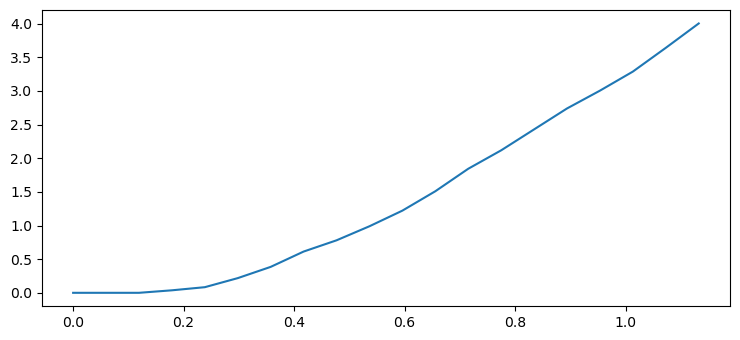

In [107]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(support, k_inhom_estimate)
plt.show()

# lets have a look at the rejected points?

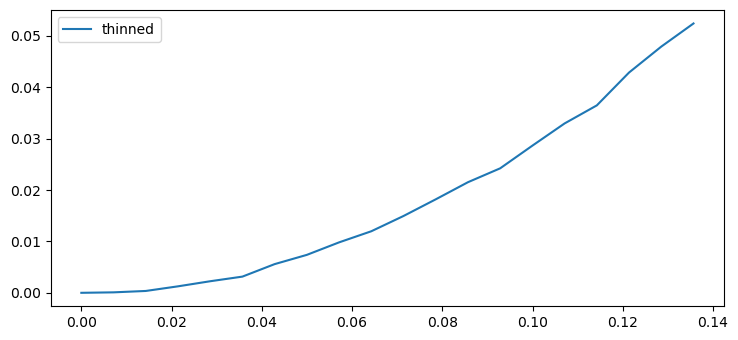

In [110]:
rejecteddata = pd.DataFrame({'x':xxThinned, 'y':yyThinned})
rejectedxy = rejecteddata[['x', 'y']].values

coordinates, support, distances, metric, hull, edge_correction = _prepare(
        rejectedxy, support=None,
    distances=None,
    metric="euclidean",
    hull=None,
    edge_correction=None,
    )

hull = _prepare_hull(rejectedxy, hull = None)

n = coordinates.shape[0]

upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
intensity = n / _area(hull) #INTENSITY 
k_estimate = ((n_pairs_less_than_d * 2) / n) / intensity # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
uno_fratto_a = 1/ _area(hull)
attempt_intensity_2 = n * (n - 1) / (_area(hull))**2
k_inhom_estimate_rejected = ((n_pairs_less_than_d *2) / (attempt_intensity_2)) *uno_fratto_a

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(support, k_inhom_estimate_rejected, label = 'thinned')
plt.legend()
plt.show()

In [23]:
k_inhom_estimate_rejected

array([0.        , 0.        , 0.00051559, 0.00257794, 0.0041247 ,
       0.00721822, 0.00773381, 0.01031175, 0.01495204, 0.01856115,
       0.02577937, 0.03093525, 0.03660671, 0.04382493, 0.05104316,
       0.05619903, 0.06341726, 0.07321342, 0.08094723, 0.08661869])

In [24]:
k_inhom_estimate

array([0.        , 0.        , 0.00051559, 0.00257794, 0.0041247 ,
       0.00721822, 0.00773381, 0.01031175, 0.01495204, 0.01856115,
       0.02577937, 0.03093525, 0.03660671, 0.04382493, 0.05104316,
       0.05619903, 0.06341726, 0.07321342, 0.08094723, 0.08661869])

# LONDON 

In [4]:
london_data = pd.read_pickle('/Users/gocchini/Desktop/paper_3/london_intangibles.pkl')

In [5]:
all_postcodes_centroids = pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')
all_postcodes_centroids = all_postcodes_centroids[['pcd', 'lat', 'long']]

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_9828/1487258132.py:1: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  all_postcodes_centroids = pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')


In [6]:
data_with_coords = london_data.merge(all_postcodes_centroids, left_on = 'postcode', right_on = 'pcd', how = 'left')

In [7]:
data_with_coords = data_with_coords[data_with_coords.postcode != 'W1W 7LT']
data_with_coords = data_with_coords[data_with_coords.postcode != 'W1B 3HH']
data_with_coords = data_with_coords[data_with_coords.postcode != 'W1W 5PF']
data_with_coords = data_with_coords[data_with_coords.postcode != 'W1T 6AD']
data_with_coords = data_with_coords[data_with_coords.postcode != 'W1F 9JG']

In [8]:
coords = data_with_coords[['lat', 'long']]

In [9]:
xy_london = data_with_coords[['lat', 'long']].values

In [12]:
coordinates, support, distances, metric, hull, edge_correction = _prepare(
        xy_london, support=None,
    distances=None,
    metric="euclidean",
    hull=None,
    edge_correction=None,
    )

hull = _prepare_hull(xy_london, hull = None)

n = coordinates.shape[0]

upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
lambda_1 = n / _area(hull) #INTENSITY 
k_estimate = ((n_pairs_less_than_d * 2) / n) / intensity # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
uno_fratto_a = 1/ _area(hull)
lambda_2 = (n * (n - 1)) / (_area(hull))**2
k_inhom_estimate_london = ((n_pairs_less_than_d *2) / (lambda_2)) * uno_fratto_a

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(support, k_inhom_estimate_london, label = 'thinned')
plt.legend()
plt.show()

NameError: name 'intensity' is not defined

In [63]:
numatax = pd.read_csv('/Users/gocchini/numatax.csv')
numatay = pd.read_csv('/Users/gocchini/numatay.csv')
numatax = numatax['x'].tolist()
numatay = numatay['x'].tolist()
numata_array = np.array(list(zip(numatax, numatay)))
coordinates, support, distances, metric, hull, edge_correction = _prepare(
        numata_array, support=None,
    distances=None,
    metric="euclidean",
    hull=None,
    edge_correction=None,
    )

hull = _prepare_hull(numata_array, hull = None)

n = coordinates.shape[0]
upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean') # OK  DISTANCES 
n_pairs_less_than_d = (upper_tri_distances < support.reshape(-1, 1)).sum(axis=1) # N PAIRS LESS THAN DISTANCES 
intensity = n / _area(hull) #INTENSITY 
k_estimate = ((n_pairs_less_than_d * 2) / n) / intensity # OK  ((N PAIRS LESS THAN DISTANCE * 2) / N POINTS )/ INTENSITY    #BRING UP THE POINT FROM BADDELEY THAT ITS SHOULD BE N-1\HULL AREAS (PP 204)
uno_fratto_a = 1/ _area(hull)
attempt_intensity_2 = n * (n - 1) / (_area(hull))**2
k_inhom_estimate_numata = ((n_pairs_less_than_d *2) / (intensity * attempt_intensity_2)) /uno_fratto_a

In [66]:
def normalizer(values):
    normalized_counts = []
    for x in values:
        normalized_counts.append(x/sum(values))
    return normalized_counts

In [69]:
k_inhom_estimate_numata_n = normalizer(k_inhom_estimate_numata)
k_inhom_estimate_n = normalizer(k_inhom_estimate)
k_inhom_estimate_london_n = normalizer(k_inhom_estimate_london)

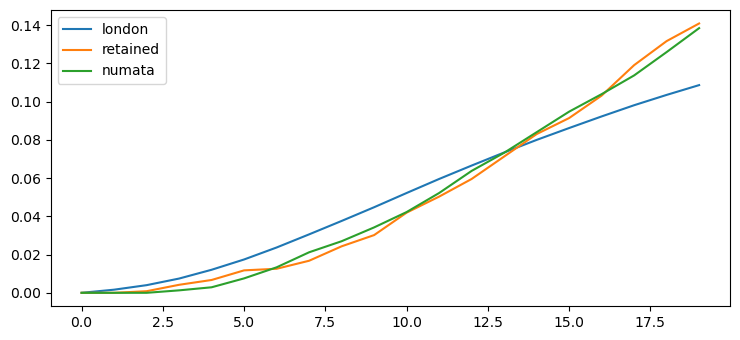

In [72]:
plt.plot(k_inhom_estimate_london_n, label = 'london')
plt.plot(k_inhom_estimate_n, label = 'retained')
plt.plot(k_inhom_estimate_numata_n, label = 'numata')
plt.legend()
plt.show()

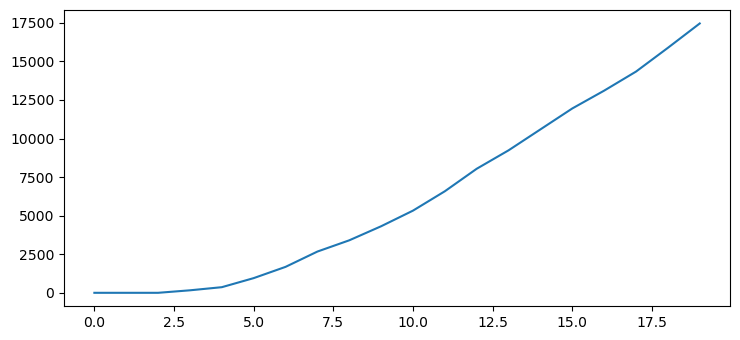

In [75]:
plt.plot(k_inhom_estimate_numata)
plt.show()

In [76]:
k_inhom_estimate_numata

array([    0.        ,     0.        ,     0.        ,   162.00165485,
         364.50372341,   951.75972225,  1680.76716907,  2673.02730503,
        3402.03475186,  4313.2940604 ,  5325.80440321,  6581.3172283 ,
        8039.33212196,  9234.09432648, 10590.85818585, 11947.62204523,
       13101.88383604, 14337.14645427, 15876.16217535, 17455.67831014])

In [77]:
# am i plotting the rigth thing ? study that 
# understand what to plot 

In [82]:
len(coordinates)

204

In [79]:
upper_tri_distances = spatial.distance.pdist(coordinates, metric='euclidean')

In [81]:
len(upper_tri_distances)

20706